In [1]:
import librosa
import librosa.display
import IPython.display as ipd
from IPython.core.display import display
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd
import os

# Mount google drive and confirm mount to access data set
# from google.colab import drive
# drive.mount('/content/drive')
# print(os.listdir(os.getcwd()))

# Visualise data

In [2]:
# List of file name with corresponding emotions
train_path = "NLP Training Dataset - Copy/ASR Training Dataset"
file_emotion = []
file_name = []
emotion_list = ['angry', 'fear', 'happy', 'neutral', 'sad']

for dir in emotion_list:
  audio_file = os.listdir(train_path + '/' + dir)
  for file in audio_file:
    file_emotion.append(dir)
    file_name.append(file)

# dataframe for file name
name_df = pd.DataFrame(file_name, columns=['FileName'])

# dataframe for file emotion
emotion_df = pd.DataFrame(file_emotion, columns=['Emotion'])
train_df = pd.concat([name_df, emotion_df], axis=1)

train_df.head(10)

,FileName,Emotion
0,00137a41c0.wav,angry
1,0013d115a0.wav,angry
2,005caa3fd8.wav,angry
3,00f5ccb1da.wav,angry
4,0111da0f76.wav,angry
5,0127445bbf.wav,angry
6,01a9917c79.wav,angry
7,01bfcfd174.wav,angry
8,02a0bc9e97.wav,angry
9,02dda0e11d.wav,angry


C:\Users\chris\anaconda3\envs\noteVenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


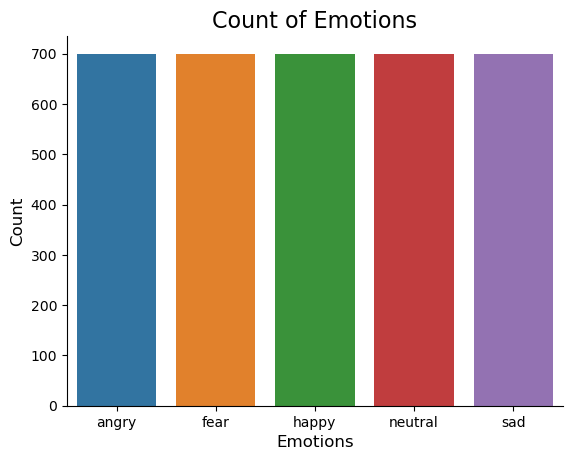

In [3]:
plt.title('Count of Emotions', size=16)
sb.countplot(train_df.Emotion)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sb.despine(top=True, right=True, left=False, bottom=False)
plt.show()

# Visualise sound

We will be using only MFCCs as features. At each time t, a vector of MFCC is produced.

In [4]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

def create_MFCC(data, sr, e):
    # https://medium.com/prathena/the-dummys-guide-to-mfcc-aceab2450fd
    hop_length = 512 # in num. of samples
    n_fft = 2048 # window in num. of samples
    MFCCs = librosa.feature.mfcc(data, sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)  
    plt.figure(figsize=(5,3))
    librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length)
    plt.xlabel("Time")
    plt.ylabel("MFCC coefficients")
    plt.colorbar()
    plt.title("MFCCs")
    plt.show()

def plot_emotion(emotion):
  path = np.array(train_df.FileName[train_df.Emotion==emotion])[1]
  file_path = train_path + '/' + emotion + '/' + path
  data, sampling_rate = librosa.load(file_path)
  print(data)
  create_waveplot(data, sampling_rate, emotion)
  create_spectrogram(data, sampling_rate, emotion)
  create_MFCC(data, sampling_rate, emotion)
  # display(ipd.Audio(file_path))

In [5]:
# plot_emotion('angry')
# plot_emotion('sad')
# plot_emotion('neutral')
# plot_emotion('happy')
# plot_emotion('fear')

# Data Augmentation functions

Functions to augment the data even further to increase samples in training set. But I did not use them in the end.

In [6]:
# Data Augmentation
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(train_df.FileName)[2]
emotion = np.array(train_df.Emotion)[2]
file_path = train_path + '/' + emotion + '/' + path
data, sample_rate = librosa.load(file_path)

# Feature extraction

At each time t, a vector of length 20 is produced. Therefore, for each sample, we have a 2D matrix. Each sample has different durations, so the matrix has the dimensions 20 x t. We need to make sure that each feature has the same dimensions though padding or truncating.

In [7]:
def pad_or_cut(matrix, desired_height, desired_width):
    h = matrix.shape[0]
    w = matrix.shape[1]
    if h <= desired_height:
        matrix = np.pad(matrix, pad_width=((0, desired_height - h)), mode='constant')
    else:
        matrix = matrix[:desired_height, :]
    if w <= desired_width:
        matrix = np.pad(matrix, pad_width=((0, 0), (0, desired_width - w)), mode='constant')
    else:
        matrix = matrix[:, :desired_width]

    return matrix

# Test pad_or_cut
temp_mat = np.arange(24).reshape((4, 6))
assert pad_or_cut(temp_mat, 5, 5).shape == (5,5)

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, offset=0.1)
    res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))    
    return pad_or_cut(res, 20, 120)
       
def get_features_with_augmentation(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.1)
    noise_data = noise(data)   
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res = np.array(librosa.feature.mfcc(data_stretch_pitch, sample_rate, n_fft=2048, hop_length=512, n_mfcc=128))
    return pad_or_cut(res, 128, 120)

# Test whether get_features return the correct shape
file_path = train_path +'/angry/00f5ccb1da.wav'
get_features(file_path)

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 5.2801366e-03  8.8961525e-03 -1.2338054e-02 ... -1.3834969e-04
  5.0726740e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))


array([[-436.96808  , -397.47668  , -384.9894   , ...,    0.       ,
           0.       ,    0.       ],
       [ -44.27086  ,  -29.461834 ,  -21.909538 , ...,    0.       ,
           0.       ,    0.       ],
       [ -14.210609 ,  -26.623672 ,  -28.922256 , ...,    0.       ,
           0.       ,    0.       ],
       ...,
       [  -5.660564 ,   -4.492699 ,   -4.9162445, ...,    0.       ,
           0.       ,    0.       ],
       [   3.7566426,    6.737926 ,    8.921848 , ...,    0.       ,
           0.       ,    0.       ],
       [   3.6303997,    2.840691 ,    3.1726763, ...,    0.       ,
           0.       ,    0.       ]], dtype=float32)

In [8]:
from tqdm import tqdm
X, y = [],[]

for path, emotion in tqdm(zip(train_df.FileName, train_df.Emotion), total=len(train_df.FileName)):
    file_path = train_path + '/' + emotion + '/' + path
    feature = get_features(file_path)
    X.append(feature)
    y.append(emotion)

X = np.array(X)
y = np.array(y)


  0%|                                                                                         | 0/3500 [00:00<?, ?it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00069182 -0.00142776 -0.0012637  ... -0.00094543 -0.00080878
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-3.4402922e-02 -2.8517211e-03  3.8945746e-02 ... -2.1324096e-04
 -3.4611741e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.02583867 -0.00616516 -0.01436703 ... -0.00042283 -0.00131665
  0.        ], sr=22050 as keyword args. From version 0.10 pa

  1%|▌                                                                               | 24/3500 [00:00<01:56, 29.96it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00795802 0.0078023  0.00572047 ... 0.00229455 0.00245112 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-3.7599599e-05 -2.0009973e-05 -2.8589722e-05 ...  4.2948785e-05
  1.0770586e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-1.1028136e-06 -1.2487750e-06 -1.0556508e-06 ...  1.3542393e-03
  1.1052255e-03  0.0000000e+00], sr=22050 as keyword args. From vers

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.0200059  0.04267523 0.04918783 ... 0.00024056 0.00133994 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
  1%|█                                                                               | 47/3500 [00:01<02:03, 28.07it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[1.5823221e-05 3.2279862e-05 1.4799120e-06 ... 2.1356656e-05 2.6021398e-05
 0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00422143 0.00480349 0.00405868 ... 0.00220597 0.00242856 0.        ], sr=22050 as keyword args. From version 0.10 passing these as posit

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.01378051  0.03548276 -0.00513422 ... -0.001306   -0.00036254
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00783685  0.00805368  0.00463352 ... -0.00838044 -0.00954829
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00083321 -0.00092259 -0.00082646 ...  0.00028689  0.00018603
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_leng

  3%|██                                                                              | 91/3500 [00:03<02:00, 28.19it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-2.3861688e-03  1.4993672e-02  1.5175306e-02 ...  6.8144473e-05
  1.9650462e-04  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.01076189 -0.01186359 -0.01063371 ...  0.00378378  0.00310008
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.04151927  0.03462803  0.15928523 ... -0.02423454 -0.01737238
 -0.01092913], sr=22050 as keyword args. From version 0.10 pa

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00229757 0.00235948 0.00311229 ... 0.0034895  0.00789553 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00289657 -0.00331144 -0.00193205 ...  0.00041857  0.00062146
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
  3%|██▌                                                                            | 115/3500 [00:03<01:59, 28.42it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.19384702 0.28131968 0.29126072 ... 0.03174918 0.02814781 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional argume

  4%|███                                                                            | 137/3500 [00:04<01:59, 28.21it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.04390009 -0.03106105 -0.01255338 ... -0.00079737 -0.00069389
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[5.2238547e-06 5.9152494e-06 5.0004496e-06 ... 1.4185428e-03 1.4704479e-03
 0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00085747  0.00042421  0.00034931 ... -0.0007243  -0.0008412
  0.        ], sr=22050 as keyword args. From version 0.10 passing t

  5%|███▌                                                                           | 159/3500 [00:05<02:01, 27.47it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00204447 0.00199269 0.00164575 ... 0.00089813 0.00060479 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.01250611  0.01467799  0.01249558 ... -0.00648449 -0.00815139
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-6.3847085e-07 -7.2297496e-07 -6.1116612e-07 ... -2.4015899e-06
  2.1316369e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing t

  5%|████                                                                           | 181/3500 [00:06<01:57, 28.36it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00130382 -0.00186468 -0.00219107 ... -0.00125144 -0.00083237
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.03156023 0.04046433 0.03735285 ... 0.03452522 0.03469315 0.02123429], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.01271419 -0.00641125 -0.01361778 ...  0.00119959  0.0002699
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional 

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.0114655   0.01391483  0.00421052 ...  0.00227928  0.00623208
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
  6%|████▋                                                                          | 205/3500 [00:07<02:01, 27.14it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00106136  0.00122507  0.00119474 ... -0.0002783  -0.00035248
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00704129 -0.00232839 -0.00473708 ... -0.03811683 -0.03352686
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as pos

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.01097544 -0.01254244 -0.00511745 ...  0.00057608  0.00097766
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
  6%|█████                                                                          | 227/3500 [00:08<01:57, 27.75it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00138109 -0.00238931 -0.00255205 ...  0.00059399  0.00039651
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00728344 -0.00119116  0.00362295 ... -0.00043212 -0.00149038
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as pos

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-6.0488642e-06 -7.4056761e-06 -6.2508002e-06 ...  8.3826897e-05
  7.2347815e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
  7%|█████▋                                                                         | 250/3500 [00:08<01:53, 28.58it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 1.2565646e-04  1.3599843e-04  2.1119422e-04 ... -7.5647702e-05
 -7.6824232e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00230492  0.00280651  0.00238559 ... -0.00090836 -0.00082267
  0.        ], sr=22050 as keyword args. Fr

  8%|██████                                                                         | 271/3500 [00:09<02:02, 26.44it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00099485 0.00101429 0.00125891 ... 0.00084671 0.00059182 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00325996 -0.00383379 -0.00332153 ...  0.00029281 -0.00168875
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00069623 -0.0007577  -0.00075791 ... -0.00026337 -0.00019722
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional

  8%|██████▋                                                                        | 295/3500 [00:10<01:57, 27.28it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 1.9734553e-06  2.2346489e-06  1.8890591e-06 ... -3.0186059e-04
 -3.2521290e-04  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 8.1348566e-07  3.5482750e-05 -2.1027885e-05 ...  4.3338983e-05
  5.8663059e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.01978265  0.00369329  0.02689581 ...  0.00096458  0.00070407
  0.        ], sr=22050 as keyword args. Fr

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00696421 0.00737063 0.00541036 ... 0.00553913 0.00395731 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
  9%|███████▏                                                                       | 318/3500 [00:11<01:51, 28.59it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[1.0679873e-05 1.2093400e-05 1.0223142e-05 ... 8.6084701e-06 6.3536268e-06
 0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.02076728 -0.04040161 -0.00686747 ... -0.02340305 -0.02115566
  0.        ], sr=22050 as keyword args. From version 0.10 passing these a

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 1.9381285e-05  1.5167319e-05  1.4066610e-05 ... -1.8462945e-04
 -1.4546108e-04  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.20607363 -0.26919693 -0.24736667 ... -0.00770871 -0.0080476
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 10%|███████▋                                                                       | 341/3500 [00:12<01:57, 26.79it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00808383  0.00918828  0.00708203 ... -0.0034195  -0.00373474
  0.        ], sr=22050 as keyword args. From version 0.10 pas

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00263761 0.00297071 0.00275541 ... 0.00184843 0.00226111 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00209872 -0.00228882 -0.0017548  ...  0.0001586  -0.00018022
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 10%|████████▏                                                                      | 363/3500 [00:12<01:53, 27.61it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00986858  0.00226475 -0.00366932 ...  0.00065152  0.00114121
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.0080332  -0.00782125  0.00485314 ... -0.00012763 -0.00030654
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 11%|████████▋                                                                      | 384/3500 [00:13<01:44, 29.75it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.01243701  0.01027382  0.00414059 ... -0.00123125 -0.00117351
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00506272 -0.00682773 -0.00532474 ... -0.00128767 -0.00117539
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as pos

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00986389 -0.00244129  0.01000693 ...  0.00102484  0.00026038
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 12%|█████████▏                                                                     | 407/3500 [00:14<01:50, 27.94it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00074317  0.00081945  0.00070722 ... -0.00018507 -0.0002144
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 6.2937788e-03 -9.2839717e-04 -5.6570722e-03 ... -1.1707049e-04
  2.2680970e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 pas

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.01219743  0.01366449  0.0125755  ... -0.00182727 -0.00196705
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 12%|█████████▋                                                                     | 429/3500 [00:15<01:50, 27.87it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-3.0699970e-02  2.1732859e-02  1.0096432e-03 ... -6.9719978e-04
  2.3012642e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.08585113  0.08913663  0.06451563 ...  0.00373174 -0.0010436
  0.        ], sr=22050 as keyword args. From version 0.10 pas

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 2.0424418e-04  4.4066415e-04 -8.1285223e-05 ... -3.0741254e-03
 -2.5925096e-03  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.05246115 -0.04457275 -0.01188566 ... -0.23655657 -0.21733266
 -0.12143738], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 13%|██████████▏                                                                    | 452/3500 [00:16<01:49, 27.72it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.04194473 -0.05223932 -0.06861039 ... -0.00581766 -0.00577337
 -0.0032009 ], sr=22050 as keyword args. From version 0.10 pa

 13%|██████████▋                                                                    | 472/3500 [00:16<01:43, 29.12it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 3.5757071e-03 -1.4725227e-02 -1.3345453e-03 ...  2.0486237e-04
  5.3696594e-06  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00705983  0.00833702  0.0071373  ... -0.00727319 -0.00710177
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00415245  0.00486615  0.0037548  ... -0.00254911 -0.00153393
  0.        ], sr=22050 as keyword args. From version 0.10 pa

 14%|███████████▏                                                                   | 494/3500 [00:17<01:40, 30.00it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 5.2291784e-03 -7.6376315e-04 -2.0910351e-02 ...  6.6398370e-01
  7.9841882e-01  5.5196160e-01], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[6.7473840e-05 9.4560096e-03 1.6927345e-04 ... 7.9739967e-04 2.5614002e-04
 0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-1.3926277e-03 -2.0913482e-03 -2.2645777e-03 ...  7.5866708e-05
  8.6087734e-05  0.0000000e+00], sr=22050 as keyw

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[6.9651378e-06 7.8869962e-06 6.6672683e-06 ... 5.0448794e-03 3.0588291e-03
 0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 15%|███████████▋                                                                   | 517/3500 [00:18<01:41, 29.48it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00113544 0.001336   0.00113157 ... 0.00035176 0.00048327 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 9.4695031e-05  8.2500170e-05  1.9812531e-05 ... -1.7807091e-05
 -3.4843368e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.

 15%|████████████▏                                                                  | 538/3500 [00:19<01:50, 26.87it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00048344 -0.00054742 -0.00046276 ... -0.00139899 -0.00635975
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00953514  0.01032619  0.00841746 ... -0.00425429 -0.0038983
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.03055372 -0.08497084 -0.22126454 ...  0.00510367  0.00849636
  0.00745117], sr=22050 as keyword args. From version 0.10 passing these as posi

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00333867  0.00447092  0.00480699 ... -0.00046966 -0.00071354
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 16%|████████████▋                                                                  | 562/3500 [00:19<01:48, 27.13it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00140171 0.0008023  0.00021125 ... 0.00020105 0.00038482 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 1.06638618e-04  1.21766549e-04  1.00544370e-04 ... -6.84715314e-06
  1.44623455e-05  0.00000000e+00], sr=22050 as keyword args. From version 0.10 pas

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00286883  0.00383182  0.00360847 ... -0.00305515 -0.00583506
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.11447211  0.12305912  0.072801   ... -0.26260176 -0.46991158
 -0.39148727], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 17%|█████████████▏                                                                 | 586/3500 [00:20<01:41, 28.58it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00031156 0.00030794 0.00046309 ... 0.0084588  0.00478258 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00750712  0.01473453  0.00085126 ... -0.00088129 -0.00033945
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 18%|██████████████▏                                                                | 629/3500 [00:22<01:34, 30.51it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.01560746  0.01006943  0.01046386 ... -0.00011088 -0.00033156
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.02242847  0.01026445 -0.02154794 ...  0.0013991   0.00075728
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as pos

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00183275  0.00198433  0.00153758 ... -0.00160163 -0.00187354
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 19%|██████████████▋                                                                | 652/3500 [00:23<01:40, 28.37it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00116933 -0.0014855  -0.00149788 ...  0.00114997  0.00095178
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00044267 -0.000481   -0.00042775 ... -0.00075114 -0.00071794
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as pos

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 6.7659224e-05  3.2163662e-05 -1.6592976e-05 ...  8.6679094e-04
  4.6696738e-04  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 19%|███████████████▏                                                               | 674/3500 [00:23<01:38, 28.59it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00770184 -0.00080196 -0.00405744 ... -0.00015168 -0.00010724
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00667128  0.0096694  -0.00215436 ...  0.00088988  0.00087328
  0.        ], sr=22050 as keyword args. From version 0.10 pa

 20%|███████████████▋                                                               | 695/3500 [00:24<01:39, 28.15it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00231003  0.0026093   0.00213401 ... -0.00728788 -0.0056015
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00278782 -0.00197798 -0.0005048  ...  0.00308432  0.00271478
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00301469 0.00263174 0.00268435 ... 0.00511556 0.00373411 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional 

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00042089  0.00039997  0.00033522 ... -0.00071314 -0.00062631
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 4.3546392e-05  7.7801946e-05  1.1043716e-04 ...  1.2280445e-03
 -6.9444586e-04  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 21%|████████████████▎                                                              | 720/3500 [00:25<01:17, 36.05it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.04335749 0.05793265 0.0712628  ... 0.00073919 0.00074381 0.        ], sr=22050 as keyword args. From version 0.10 passing t

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-5.2954424e-03 -6.3023414e-03 -5.5602258e-03 ...  4.2039050e-05
  2.9539928e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00024796 -0.00026023 -0.00020191 ...  0.00286204  0.00356429
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 22%|█████████████████▏                                                             | 764/3500 [00:26<01:21, 33.62it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.01984154  0.00785135  0.01585368 ... -0.00842825 -0.00484524
  0.        ], sr=22050 as keyword args. From version 0.10 pa

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-7.9707985e-05 -4.4108109e-04 -8.1402826e-04 ...  5.8837031e-04
  2.7329946e-04  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 23%|██████████████████▏                                                            | 808/3500 [00:27<01:20, 33.24it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00081348 0.00083073 0.00073517 ... 0.00046726 0.00016273 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00081487 -0.00096518 -0.00085341 ... -0.00322071 -0.00357983
  0.        ], sr=22050 as keyword args. From version 0.10 passing t

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00678235 0.01815369 0.0045232  ... 0.00054871 0.00157523 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 8.30153294e-05 -5.17934714e-05 -1.08373664e-04 ...  2.76487757e-04
  1.71925582e-04  0.00000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 24%|██████████████████▊                                                            | 832/3500 [00:28<01:14, 35.67it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00195287 0.00268404 0.00236501 ... 0.00394893 0.00313072 0.        ], sr=22050 as keyword args. From version 0.10 passing th

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-8.7555985e-05 -6.5832857e-05 -3.4735109e-05 ... -1.5957732e-04
 -1.8100371e-04  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 25%|███████████████████▊                                                           | 876/3500 [00:29<01:24, 30.98it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00342216 0.00319388 0.00222375 ... 0.00236982 0.00254851 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-4.6775614e-05 -5.6497833e-05 -5.1724986e-05 ...  5.4471038e-04
  7.2521938e-04  0.0000000e+00], sr=22050 as keyword args. From vers

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00340693 -0.00360519 -0.00388139 ... -0.00264212 -0.00093918
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.01854994  0.01978571  0.01095143 ... -0.01117387 -0.00146876
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00028309 0.00030011 0.00015131 ... 0.00412504 0.00473977 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512,

 26%|████████████████████▊                                                          | 920/3500 [00:31<01:11, 35.99it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00110354  0.00814504  0.0064515  ... -0.00314924 -0.00496312
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 6.4463128e-04  9.1077207e-04  3.9018970e-04 ... -1.9818966e-05
 -3.5410445e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 5.6013112e-05  5.0003793e-05  2.6581702e-05 ... -2.0682996e-03
 -2.2002903e-03  0.0000000e+00], sr=22050 as keyword args. Fr

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00037203  0.00040731  0.0003713  ... -0.00062703 -0.00042743
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00127426 0.00146514 0.00117598 ... 0.00198198 0.00157042 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 27%|█████████████████████▎                                                         | 944/3500 [00:31<01:12, 35.05it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.03275098  0.02255496  0.00513932 ...  0.00033042 -0.0005828
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional 

 28%|█████████████████████▊                                                         | 965/3500 [00:32<01:24, 30.06it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-1.1601365e-04 -7.7701829e-05  1.3584882e-04 ...  4.1353973e-03
  3.4068013e-03  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00037609  0.00043323  0.00036038 ... -0.00981593 -0.01035974
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 8.0763968e-04  8.7006314e-04  7.0341426e-04 ... -2.7696026e-06
 -2.4594810e-05  0.0000000e+00], sr=22050 as keyword args. Fr

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.02137904 -0.00059698 -0.00024574 ... -0.00538811 -0.00481207
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 28%|██████████████████████▎                                                        | 989/3500 [00:33<01:15, 33.42it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 4.9564051e-03  5.8108388e-05 -9.3815429e-03 ... -2.8780913e-03
  2.5710070e-03  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00064683  0.00252731  0.00796289 ...  0.00173424  0.00182422
  0.        ], sr=22050 as keyword args. From version 0.10 pa

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00215813 -0.00183716 -0.00097081 ...  0.00066756  0.00065117
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00173541 -0.00186976 -0.00129188 ... -0.00089569 -0.00057934
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.01242052 -0.02673629 -0.03875173 ... -0.00207112 -0.00173966
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_leng

 30%|███████████████████████                                                       | 1033/3500 [00:34<01:13, 33.40it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00073932 -0.00092253 -0.00079681 ... -0.00103326 -0.00123954
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00052105 -0.00093546 -0.00074103 ... -0.00640865 -0.00380597
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 8.548570e-03  9.653575e-03  7.941002e-03 ... -6.333315e-05 -5.427865e-05
  0.000000e+00], sr=22050 as keyword args. From version 0.10 passing 

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-2.5884871e-04 -2.2045404e-04 -1.5980132e-04 ...  1.7779044e-04
  2.8211734e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-2.0187807e-03 -8.8745241e-05  1.0902835e-03 ... -1.5310183e-03
 -1.3386516e-03  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 30%|███████████████████████▌                                                      | 1057/3500 [00:35<01:13, 33.23it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[8.5627616e-05 4.0638639e-05 3.4836085e-05 ... 2.4938697e-04 3.2263817e-04
 0.0000000e+00], sr=22050 as keyw

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.02151852  0.02346446  0.01757606 ... -0.00310879 -0.00313291
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00781415  0.01090465  0.00165626 ...  0.00340739  0.00377414
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 31%|████████████████████████▌                                                     | 1101/3500 [00:36<01:10, 34.20it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00906259  0.00678134  0.00206769 ... -0.00414529 -0.00318562
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as pos

 32%|█████████████████████████                                                     | 1122/3500 [00:37<01:05, 36.22it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-5.3822459e-04  8.1343191e-05  5.2914012e-04 ... -1.2529319e-03
 -1.3539278e-03  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00333685  0.00229253 -0.00314202 ...  0.00067476 -0.00107607
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00031577 -0.00037539 -0.00109122 ...  0.00012692  0.00015537
  0.        ], sr=22050 as keyword args. From version 0.10 pa

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.001635    0.00029962  0.00181761 ... -0.00205784 -0.00250595
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.01033791  0.0008426   0.00515129 ...  0.00058231  0.00472695
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[3.9992778e-04 6.1275536e-04 5.9245568e-04 ... 1.9247852e-04 5.2839641e-05
 0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=20

 34%|██████████████████████████▌                                                   | 1190/3500 [00:39<01:06, 34.52it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00081367 -0.00024999 -0.00224973 ... -0.00058207 -0.00170028
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00042161 -0.00011267  0.00896524 ...  0.00934288  0.00701917
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00055791 -0.00044552 -0.00010452 ... -0.00282878 -0.00272675
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as pos

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-5.6591368e-04 -3.0970402e-04 -9.8964090e-05 ...  4.2831218e-03
  2.5255126e-03  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00324553  0.00399679  0.0032293  ... -0.0012955  -0.00097313
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 35%|███████████████████████████                                                   | 1215/3500 [00:39<01:06, 34.24it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[4.5050923e-03 2.2494486e-03 4.2843306e-04 ... 6.5785018e-05 1.1446435e-03
 0.0000000e+00], sr=22050 as keyword args. From ver

 35%|███████████████████████████▌                                                  | 1236/3500 [00:40<01:09, 32.72it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-7.8966754e-05 -7.0909999e-05 -8.1937469e-05 ... -2.8322451e-04
 -2.8233917e-04  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.02136369  0.0209622   0.01056171 ... -0.00047442 -0.00042406
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00018439  0.00054114  0.00019887 ... -0.00161089 -0.00174352
  0.        ], sr=22050 as keyword args. From version 0.10 pa

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.01617341 -0.00219618  0.00859683 ... -0.00219122 -0.00229953
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 2.3709897e-02 -2.7495554e-02  4.3476983e-03 ... -1.1297352e-04
 -3.2234617e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 36%|████████████████████████████                                                  | 1260/3500 [00:41<01:11, 31.17it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00048685 0.00077651 0.00032593 ... 0.00043231 0.0007874  0.        ], sr=22050 as keyword args. From version 0.10 passing t

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00896248  0.02959645  0.00267067 ...  0.00061741  0.00115939
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00286971 -0.0030873  -0.0024723  ... -0.00217712 -0.00189107
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 37%|█████████████████████████████                                                 | 1304/3500 [00:42<01:12, 30.47it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00886838 -0.00811394 -0.00760919 ...  0.00492932 -0.01034879
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as pos

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00612154 0.00707979 0.00688562 ... 0.00661475 0.00583558 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00600585 -0.00707767 -0.00696168 ... -0.01153414 -0.01269843
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.01198683  0.01102836  0.02530893 ...  0.00081672 -0.00169803
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512,

 39%|██████████████████████████████                                                | 1348/3500 [00:44<01:03, 33.79it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-9.8051988e-03 -1.1162596e-02  9.7672483e-03 ... -5.9607328e-04
  4.7296875e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00097989 0.00122048 0.00143452 ... 0.00258929 0.00315095 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00048007 -0.00083835 -0.00249972 ... -0.00352911 -0.00297963
  0.        ], sr=22050 as keyword args. From version 0.10 passing t

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[9.7353850e-06 1.7957305e-05 5.3577755e-06 ... 1.7054983e-03 1.6372690e-03
 0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 39%|██████████████████████████████▌                                               | 1372/3500 [00:44<01:03, 33.54it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00216771  0.00231751  0.00191676 ... -0.00539966 -0.00401262
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-1.3804307e-05  1.7671471e-05  4.0146511e-05 ...  4.4269205e-04
  1.5690207e-04  0.0000000e+00], sr=22050 as keyword args. From ver

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00345843  0.00175048  0.00744848 ...  0.00038847  0.00051634
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 40%|███████████████████████████████                                               | 1396/3500 [00:45<01:04, 32.42it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00076173  0.00096962  0.0009369  ... -0.00155219 -0.0014677
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00024486 -0.00091708 -0.00050151 ... -0.01243047  0.01038229
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as posi

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00267248  0.00299513  0.00252487 ... -0.00124628 -0.00098096
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.50445575 -0.6285841  -0.5920704  ...  0.26047242  0.30175856
  0.20179155], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00081739  0.0008663   0.00053438 ... -0.002818   -0.00254912
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_leng

 41%|████████████████████████████████                                              | 1440/3500 [00:46<01:04, 31.95it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00289472  0.00147881 -0.00168157 ...  0.01145039  0.01517034
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00130773 -0.00119922 -0.00056355 ... -0.00048695 -0.00040485
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.0005099  -0.00273815 -0.00111005 ... -0.02233416 -0.02223667
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as pos

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-1.3972656e-03 -1.0011591e-03 -3.3059702e-03 ...  8.6950065e-05
  1.1264858e-04  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00335657  0.0080034   0.00861104 ... -0.00729709 -0.00460195
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 42%|████████████████████████████████▋                                             | 1464/3500 [00:47<01:07, 30.31it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00467512  0.00268624  0.00122048 ...  0.00033134 -0.00017955
  0.        ], sr=22050 as keyword args. From version 0.10 pa

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.02242485  0.00419068 -0.02648315 ... -0.00430357 -0.0034646
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 43%|█████████████████████████████████▌                                            | 1508/3500 [00:49<01:05, 30.33it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00456335 -0.0008024  -0.00136765 ...  0.0123629   0.00543534
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[7.3223426e-03 9.0928394e-03 7.3553664e-03 ... 3.2261526e-03 8.0050813e-05
 0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing t

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00375806 -0.00384182 -0.0033158  ...  0.0026728   0.00304193
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00166064  0.00061455 -0.00374156 ...  0.00041906  0.00018942
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 44%|██████████████████████████████████▏                                           | 1532/3500 [00:49<00:58, 33.67it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00338437  0.00424051  0.00625072 ... -0.00031277 -0.00115407
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as pos

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.25578663 -0.27349773 -0.17648244 ...  0.28100222  0.2486296
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 45%|███████████████████████████████████                                           | 1576/3500 [00:51<01:10, 27.27it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 5.2741739e-06  2.6419171e-05  3.9123057e-05 ... -1.6209764e-03
 -1.5555483e-03  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-1.5075470e-03  4.9958639e-03 -5.3392031e-04 ...  1.9709392e-04
  9.2175054e-05  0.0000000e+00], sr=22050 as keyword args. Fro

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00494198 -0.00603881 -0.0052609  ...  0.00305307  0.00313477
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00607103 -0.00648057 -0.00446751 ... -0.00120403 -0.00167375
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 46%|███████████████████████████████████▋                                          | 1599/3500 [00:52<00:59, 31.93it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 1.1028136e-06  1.2487750e-06  1.0556508e-06 ...  2.3496716e-05
 -4.5048769e-06  0.0000000e+00], sr=22050 as keyword args. From version 0.10 pa

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.32817364  0.3622888   0.3100102  ... -0.13287573 -0.11277115
 -0.05805435], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 47%|████████████████████████████████████▌                                         | 1643/3500 [00:53<00:54, 34.29it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[1.8510153e-04 5.2773179e-05 2.4703005e-04 ... 4.2790705e-03 2.3818000e-03
 0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00121332  0.0013822   0.00119076 ... -0.00014293  0.00020841
  0.        ], sr=22050 as keyword args. From version 0.10 passing 

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 3.5986534e-06  4.0749505e-06  3.4447546e-06 ...  1.4134048e-05
 -1.0041494e-04  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00314802 -0.00355173 -0.00284744 ... -0.00605669 -0.00622929
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 48%|█████████████████████████████████████▏                                        | 1667/3500 [00:54<00:52, 34.89it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00104257  0.00134711  0.00112997 ... -0.00692934 -0.01045317
  0.        ], sr=22050 as keyword args. From version 0.10 pa

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00601707 0.0074772  0.00692812 ... 0.01322316 0.0075558  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 49%|██████████████████████████████████████                                        | 1710/3500 [00:55<00:58, 30.69it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00417572  0.00532619  0.00475227 ... -0.00766367 -0.00797331
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00099876 0.00107438 0.00089138 ... 0.00405206 0.00422776 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional argume

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00630981 -0.00117567 -0.00581823 ...  0.00287213  0.00189507
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.0005534  0.00571422 0.00519049 ... 0.00777205 0.01343049 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00071019 0.00083656 0.00057485 ... 0.00105737 0.00086903 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc

 50%|███████████████████████████████████████                                       | 1754/3500 [00:57<00:54, 31.79it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00366734  0.00413888  0.00344883 ... -0.00187851 -0.00229957
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00010128  0.00013513  0.00030749 ...  0.00885488  0.00682015
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.02919996  0.01535511 -0.00725859 ... -0.00886886 -0.00968466
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as pos

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00223024  0.00143918 -0.00146049 ...  0.0291893   0.01957843
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.01326026  0.01685538  0.01660939 ... -0.09059479 -0.05876533
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 51%|███████████████████████████████████████▌                                      | 1778/3500 [00:57<00:59, 29.17it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00174563  0.00397472 -0.00335666 ...  0.00092437  0.00222339
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as pos

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-3.9280239e-06 -4.1014192e-04 -7.3468388e-04 ... -1.7988640e-04
 -7.3505862e-04  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00420617 -0.0062608  -0.0066301  ...  0.01157155  0.0095545
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 52%|████████████████████████████████████████▋                                     | 1823/3500 [00:59<00:47, 35.34it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00081609 0.00104336 0.0016535  ... 0.00055846 0.00081247 0.        ], sr=22050 as keyword args. From version 0.10 passing th

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00349063  0.00233412 -0.00561628 ... -0.00481242 -0.00296195
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 53%|█████████████████████████████████████████▌                                    | 1867/3500 [01:00<00:49, 33.12it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00034607 -0.00041627 -0.00043884 ... -0.004755   -0.00475495
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-1.3624409e-03 -1.5364725e-03 -1.2494179e-03 ...  1.0587957e-04
  1.7006927e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 pa

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00185051  0.00231658  0.00221818 ... -0.00160005 -0.00249007
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00105271  0.00157168  0.0012976  ...  0.00775932 -0.01740581
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00034803 -0.00012771 -0.00091066 ... -0.00041379 -0.00103753
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_leng

 55%|██████████████████████████████████████████▌                                   | 1911/3500 [01:02<00:49, 32.00it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00462625  0.00292514  0.0053106  ... -0.00049182  0.00081052
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.0077105  -0.00852621 -0.00710433 ...  0.00146801  0.00093147
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 5.4240827e-05  2.3099846e-04  3.8786783e-04 ... -1.1433767e-03
 -2.9110184e-03  0.0000000e+00], sr=22050 as keyword args. From version 0.10 pa

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[5.8158374e-05 8.0395854e-05 1.1179242e-04 ... 1.2590004e-02 1.9607410e-02
 0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00095004  0.00374335  0.00074041 ... -0.00023225 -0.00033988
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 55%|███████████████████████████████████████████                                   | 1935/3500 [01:02<00:52, 30.09it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00539411 -0.0054366  -0.00335616 ...  0.00954689  0.01056407
  0.        ], sr=22050 as keyword args. From version 0.10 passing 

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00134255 -0.00151099 -0.00115146 ... -0.0005755  -0.00926803
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00992013  0.01153191  0.01008017 ... -0.00201069 -0.00309592
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 57%|████████████████████████████████████████████                                  | 1979/3500 [01:04<00:44, 34.21it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.0028363   0.00421117 -0.00478202 ... -0.00163301 -0.00172924
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as pos

 57%|████████████████████████████████████████████▌                                 | 2000/3500 [01:04<00:46, 32.30it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00130698 -0.00219598 -0.00209214 ... -0.00836158 -0.0046775
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00205187 -0.00207154 -0.0017931  ...  0.00333916  0.00317065
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00159561 -0.00080324  0.00058688 ...  0.00194316  0.00145936
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as posi

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00018882 -0.00040767 -0.00042165 ...  0.00136067  0.00277994
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00414046 0.00444845 0.0039588  ... 0.00118258 0.00104596 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 58%|█████████████████████████████████████████████                                 | 2024/3500 [01:05<00:45, 32.12it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-9.28684983e-07 -1.05159961e-06 -8.88968941e-07 ...  1.06545864e-04
  4.35706061e-05  0.00000000e+00], sr=22050 as keyword args. From version 0.10 pas

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00313076 -0.00215091  0.00340828 ... -0.00041068 -0.00029027
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 58%|█████████████████████████████████████████████▌                                | 2046/3500 [01:06<00:47, 30.81it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00733133  0.02289102  0.04302924 ...  0.03812329  0.00766502
 -0.02579388], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-3.06303788e-04 -2.33375931e-06  1.00556626e-05 ...  1.52089475e-02
  1.22459084e-02  0.00000000e+00], sr=22050 as keyword args. From version 0

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00017299 -0.0063389   0.00334286 ...  0.00090454  0.00202611
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00017331 -0.00022704 -0.00016316 ...  0.00371955  0.00418094
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.19791402 -0.21674658 -0.17048694 ... -0.00025804 -0.0006807
 -0.00069981], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_lengt

 60%|██████████████████████████████████████████████▌                               | 2090/3500 [01:07<00:46, 30.58it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00604923 -0.00662666 -0.00537317 ... -0.01299575 -0.01299063
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.01138726 -0.00292718  0.00572044 ...  0.00067778  0.00029631
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00751878 -0.00055858 -0.00808976 ...  0.00764746  0.00800411
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as pos

 60%|███████████████████████████████████████████████                               | 2113/3500 [01:08<00:47, 29.10it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00063262  0.00067854  0.00075345 ...  0.00634905  0.00597461
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-1.1567629e-04 -1.0090853e-04 -2.3898981e-05 ... -7.9282225e-05
 -7.7617296e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-4.2371239e-06 -4.7979229e-06 -4.0559207e-06 ...  8.7409513e-04
  8.4093149e-04  0.0000000e+00], sr=22050 as keyword args. Fr

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-2.0567921e-05  8.6062500e-05 -8.1351027e-05 ...  3.7043725e-04
  4.3860739e-04  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00056596  0.00010465 -0.00010872 ...  0.00317085  0.00288132
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 61%|███████████████████████████████████████████████▌                              | 2137/3500 [01:09<00:51, 26.42it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00072234  0.0001783   0.00023414 ...  0.00106816  0.00119129
  0.        ], sr=22050 as keyword args. From version 0.10 pa

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00090147  0.00183773  0.0009322  ... -0.00346735 -0.00389601
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 62%|████████████████████████████████████████████████                              | 2159/3500 [01:10<00:44, 30.17it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.0167796  -0.0195612  -0.01660053 ... -0.00114538 -0.00051508
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.02645079  0.03100264  0.02619048 ... -0.01715095 -0.01919266
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as pos

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.0005957  -0.00089054 -0.00051566 ...  0.02907717  0.02669535
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 62%|████████████████████████████████████████████████▌                             | 2181/3500 [01:10<00:46, 28.13it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-1.3930276e-05 -1.5773992e-05 -1.3334537e-05 ... -8.5555630e-06
 -7.9520969e-06  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00480262  0.0059131   0.00571898 ... -0.0008864  -0.00104255
  0.        ], sr=22050 as keyword args. From version 0.10 pa

 63%|█████████████████████████████████████████████████                             | 2203/3500 [01:11<00:40, 31.67it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00320914  0.00383136  0.00339958 ... -0.00159555 -0.00128553
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-3.3625111e-06  2.1120571e-03  3.6833170e-03 ...  1.1741003e-03
  4.6779370e-04  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.0019739   0.00207121  0.00154744 ... -0.00092689 -0.00175744
  0.        ], sr=22050 as keyword args. From version 0.10 pa

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00329448  0.00384319  0.00481196 ... -0.00553647 -0.00327196
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.0043985  -0.00430699 -0.00465523 ... -0.00971201 -0.01057309
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 64%|█████████████████████████████████████████████████▋                            | 2227/3500 [01:12<00:42, 29.73it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.04784475 -0.06489699 -0.06708728 ... -0.00492337 -0.00488325
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as pos

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.02671946 0.02895556 0.02045668 ... 0.00798541 0.00647262 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00054946 -0.00140832 -0.0039855  ...  0.00129881  0.0010128
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 64%|██████████████████████████████████████████████████                            | 2249/3500 [01:13<00:44, 28.02it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00913347  0.00992577  0.0082478  ... -0.00142409 -0.00077706
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional 

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 1.3349842e-06  1.5116750e-06  1.2778928e-06 ... -2.4846764e-04
 -1.1151675e-04  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 65%|██████████████████████████████████████████████████▌                           | 2270/3500 [01:14<00:48, 25.21it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.01195098  0.01404354  0.01085041 ... -0.00146577 -0.00277404
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 3.3664828e-06  3.8120504e-06  3.2225128e-06 ... -1.2382572e-04
 -2.9774150e-04  0.0000000e+00], sr=22050 as keyword args. Fr

 65%|███████████████████████████████████████████████████                           | 2292/3500 [01:14<00:44, 27.18it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.03866109 -0.00816398 -0.05392653 ...  0.00610677  0.00394231
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[2.7491927e-01 3.9985710e-01 3.9433977e-01 ... 2.0911334e-04 1.7825421e-03
 0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00280041 0.00384133 0.00398419 ... 0.00712746 0.00793882 0.        ], sr=22050 as keyword args. From version 0.10 passing these a

 66%|███████████████████████████████████████████████████▌                          | 2314/3500 [01:15<00:42, 28.22it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00050825  0.00025708  0.00013027 ... -0.00489318 -0.00311632
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-5.8042811e-08 -6.5724976e-08 -5.5560559e-08 ...  8.4873347e-05
  1.5592789e-04  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00128654 -0.00192541 -0.00046354 ...  0.25671032  0.24047227
  0.        ], sr=22050 as keyword args. From version 0.10 pa

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.02189046 0.02470793 0.02051565 ... 0.00352715 0.00302006 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 67%|████████████████████████████████████████████████████                          | 2338/3500 [01:16<00:35, 32.81it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[5.1077668e-06 5.7837997e-06 4.8893289e-06 ... 1.6490357e-04 9.6116921e-05
 0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00315343 -0.00316214 -0.00197423 ...  0.00642631  0.00667602
  0.        ], sr=22050 as keyword args. From version 0.10 passing these a

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00021303  0.00024142  0.00014265 ... -0.0003023  -0.00033026
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.01981335 0.02706966 0.0244265  ... 0.00795892 0.00691769 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 67%|████████████████████████████████████████████████████▋                         | 2362/3500 [01:17<00:38, 29.62it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00369382 -0.00335203 -0.00226412 ... -0.01069719 -0.01456766
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.12756139 -0.18663774 -0.2245463  ...  0.00140676 -0.00174092
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.01511944 -0.01565952 -0.00934698 ... -0.00049461 -0.00158119
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 68%|█████████████████████████████████████████████████████▏                        | 2386/3500 [01:17<00:38, 28.95it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-4.0629968e-07 -4.6007497e-07 -3.8892389e-07 ...  8.3464496e-05
  2.3548644e-04  0.0000000e+00], sr=22050 as keyword args. From version 0.10 pa

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00024326 0.00073695 0.00176605 ... 0.00482013 0.00671796 0.00473749], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00278788 -0.00311058 -0.00291532 ...  0.01982315  0.02109369
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.01489746 -0.01623158 -0.01380865 ... -0.0045862  -0.00394235
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512,

 69%|██████████████████████████████████████████████████████▏                       | 2429/3500 [01:19<00:38, 27.52it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.3030508  -0.28903764 -0.1638072  ... -0.00917075 -0.010197
 -0.0041102 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.01027602 -0.05539044 -0.1168815  ...  0.04547106 -0.04308928
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-7.94352149e-04 -6.53660332e-04 -5.49750519e-04 ... -1.47011115e-05
 -1.29754926e-05  0.00000000e+00], sr=22050 as keyword args. From version 0.1

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00201387 -0.00201792 -0.00124007 ...  0.00227505  0.0017087
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 8.4844459e-04  2.1021844e-04 -3.3522872e-04 ... -3.6552614e-01
 -4.4754338e-01  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 70%|██████████████████████████████████████████████████████▋                       | 2453/3500 [01:20<00:35, 29.76it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.03148026 0.03524275 0.02971194 ... 0.00034732 0.00033348 0.        ], sr=22050 as keyword args. From version 0.10 passing th

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00156862 -0.00199088 -0.00142756 ... -0.00073529 -0.00018288
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.0011907   0.02502008  0.03547487 ... -0.00707738 -0.00728936
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 71%|███████████████████████████████████████████████████████▏                      | 2476/3500 [01:20<00:34, 30.01it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[2.920575e-04 7.578369e-04 9.668519e-04 ... 2.031425e-05 2.599155e-05
 0.000000e+00], sr=22050 as keyword args. From version 0.10 passing these 

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00242312  0.0029459   0.00294455 ... -0.00270777 -0.00195576
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.04538731 -0.03090838 -0.00372274 ...  0.06311658 -0.01157546
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 71%|███████████████████████████████████████████████████████▋                      | 2498/3500 [01:21<00:35, 28.46it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00875517 0.01014448 0.00858499 ... 0.00246573 0.00230097 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.01275333 -0.01305862 -0.00986332 ... -0.01111859 -0.0078407
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 72%|████████████████████████████████████████████████████████▏                     | 2521/3500 [01:22<00:33, 29.50it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00295186 0.0029913  0.00235999 ... 0.0021084  0.00181856 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-1.5503641e-05 -1.8395724e-05 -1.0463583e-05 ... -9.3561457e-04
 -7.6368719e-04  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing th

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00608895  0.00508873  0.00337164 ... -0.0100388  -0.00510351
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00401429  0.00480037  0.00421066 ... -0.00239064 -0.00231413
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 73%|████████████████████████████████████████████████████████▋                     | 2544/3500 [01:23<00:28, 33.58it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.14352967 -0.14034139 -0.08416091 ... -0.00093517  0.00128083
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as pos

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00718139 -0.00872649  0.00744884 ... -0.0026437  -0.00189149
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-1.7180319e-03 -2.9203962e-03 -3.5250303e-03 ...  1.5088713e-05
 -1.5580012e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 74%|█████████████████████████████████████████████████████████▋                    | 2588/3500 [01:24<00:29, 30.63it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00696198  0.00850799  0.00779198 ... -0.00133714 -0.00172347
  0.        ], sr=22050 as keyword args. From version 0.10 pa

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-2.2960959e-04 -3.5798259e-04 -4.3124022e-04 ... -6.7705325e-05
 -6.9589827e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 75%|██████████████████████████████████████████████████████████▋                   | 2632/3500 [01:26<00:30, 28.67it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.01125762  0.01303718  0.01221356 ... -0.00108994 -0.0010903
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[4.9821392e-05 5.3990319e-05 2.4397636e-05 ... 4.7579957e-05 4.2399581e-05
 0.0000000e+00], sr=22050 as keyword args. From vers

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00469339 -0.00552553 -0.0047369  ...  0.00464838  0.00291482
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00229781 0.00295096 0.00261041 ... 0.00031655 0.00193836 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 76%|███████████████████████████████████████████████████████████▏                  | 2655/3500 [01:26<00:26, 31.73it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[2.5574649e-03 2.5563114e-03 2.0977398e-03 ... 7.4435105e-05 2.5841793e-05
 0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these a

 77%|████████████████████████████████████████████████████████████▏                 | 2698/3500 [01:28<00:28, 28.26it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.0059289  -0.00748026 -0.00734429 ... -0.00904722 -0.00887076
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-3.8326587e-04 -4.2608494e-04 -3.2324871e-04 ... -1.6650332e-05
  5.1100677e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.02380287 -0.02758726 -0.02382638 ...  0.00479876  0.0033072
  0.        ], sr=22050 as keyword args. From version 0.10 pas

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.01584804 0.0170013  0.00935661 ... 0.00349425 0.00326673 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 78%|████████████████████████████████████████████████████████████▋                 | 2721/3500 [01:29<00:29, 26.41it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.13977821 -0.20322798 -0.1707012  ...  0.00233095  0.00142133
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00963636  0.01220204  0.0111829  ... -0.00727148 -0.00719725
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00443289 -0.00551657 -0.0054415  ...  0.0002433   0.00045421
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00175492 0.00140066 0.00070268 ... 0.0020695  0.00391829 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[2.2107977e-05 7.3084550e-05 5.3722604e-05 ... 6.8008369e-05 1.3443928e-04
 0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00495936 -0.00762668 -0.00479106 ...  0.02486483  0.02125519
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 79%|█████████████████████████████████████████████████████████████▋                | 2766/3500 [01:30<00:26, 28.10it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 5.8814388e-04 -8.0308688e-05 -1.1970784e-03 ...  3.0653086e-01
  2.5376475e-01  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00450241 0.00439874 0.00252562 ... 0.00586272 0.0065121  0.        ], sr=22050 as keyword args. From version 0.10 passing t

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.05638597 -0.06631548 -0.05744149 ...  0.00188321  0.00067637
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00104187  0.0012966   0.00148988 ... -0.01791834 -0.02426328
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00474823  0.00488119  0.00444772 ... -0.00099419 -0.00134604
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_leng

 80%|██████████████████████████████████████████████████████████████▌               | 2810/3500 [01:32<00:23, 29.85it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00579113  0.00706502  0.00525771 ...  0.13080963 -0.07519724
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-2.2056272e-06 -2.4975500e-06 -2.1113017e-06 ...  2.2364284e-05
  2.4911389e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.03707926 -0.03721363  0.03275816 ...  0.01600214  0.01084282
  0.        ], sr=22050 as keyword args. From version 0.10 pa

 81%|███████████████████████████████████████████████████████████████               | 2832/3500 [01:32<00:23, 28.07it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00258584  0.01997336 -0.02827833 ... -0.00565124 -0.00407285
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.0077995   0.0086273   0.00717009 ...  0.00019268 -0.00028053
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00837288  0.00924282  0.00747571 ... -0.00176818 -0.00172772
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as pos

 82%|████████████████████████████████████████████████████████████████              | 2875/3500 [01:34<00:22, 28.27it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00997463 -0.00671232 -0.06781291 ... -0.03156628 -0.01899659
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-5.1437453e-03 -3.9499630e-03 -7.1453035e-04 ...  1.4886945e-04
  2.8673410e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00954395 -0.01096716 -0.00909348 ... -0.0049522  -0.00329807
  0.        ], sr=22050 as keyword args. From version 0.10 pa

 83%|████████████████████████████████████████████████████████████████▌             | 2899/3500 [01:35<00:20, 28.96it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.02910094 -0.01934379 -0.03778939 ... -0.00028603  0.00060901
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-1.3649266e-04 -5.4384756e-05 -1.4749690e-05 ... -2.5537817e-04
 -1.6654067e-04  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00462153 -0.00453223 -0.00345314 ...  0.0060264   0.00408626
  0.        ], sr=22050 as keyword args. From version 0.10 pa

 83%|█████████████████████████████████████████████████████████████████             | 2922/3500 [01:36<00:20, 28.43it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00146555 0.00188767 0.00167433 ... 0.00180575 0.00166827 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 9.8672763e-07  1.1173245e-06  9.4452957e-07 ... -1.2034154e-05
  2.4783907e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00082456  0.00105847  0.00113753 ... -0.02311496 -0.02533635
  0.        ], sr=22050 as keyword args. From version 0.10 passing t

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 2.9077637e-05 -1.7321158e-04 -2.6221343e-04 ... -1.6346220e-03
 -1.7528848e-03  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.01366507 -0.01677408 -0.01649894 ...  0.01854623  0.01695385
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 84%|█████████████████████████████████████████████████████████████████▋            | 2946/3500 [01:37<00:21, 25.28it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.03802298 -0.05183287  0.04349492 ...  0.00330923  0.00237902
  0.        ], sr=22050 as keyword args. From version 0.10 pa

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.03818403  0.04070389  0.03350186 ... -0.00025617 -0.00022487
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 85%|██████████████████████████████████████████████████████████████████            | 2967/3500 [01:38<00:21, 25.31it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.02138828 -0.02571111 -0.02415077 ...  0.00113074  0.00094825
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.0348147  -0.01224305  0.01591098 ...  0.02190411  0.01701174
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as pos

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00024896  0.00038074  0.00019746 ... -0.0009012  -0.00063289
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 85%|██████████████████████████████████████████████████████████████████▋           | 2990/3500 [01:38<00:19, 25.67it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-5.0195321e-03 -4.4525280e-03 -5.2081821e-03 ...  5.8829901e-05
  1.2198089e-03  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 2.0113225e-04  1.5535121e-04  6.9894777e-05 ... -4.6228757e-04
 -1.3601232e-03  0.0000000e+00], sr=22050 as keyword args. Fr

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00301276  0.00317387  0.00168431 ... -0.00753677 -0.00647092
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 86%|███████████████████████████████████████████████████████████████████           | 3012/3500 [01:39<00:16, 29.55it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.01897047 -0.03713318 -0.05683014 ...  0.00185322  0.00156561
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00537107 -0.00357442 -0.00314534 ...  0.00396832  0.0029072
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as posi

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00725891 -0.00822972 -0.00634374 ...  0.04541803  0.02711222
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[1.8312709e-04 2.2295862e-04 1.2391320e-04 ... 9.0362555e-05 4.3116986e-05
 0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-7.3412340e-03 -8.6379182e-03 -8.3334930e-03 ... -3.2747612e-05
 -4.1082012e-04  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sam

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.05407908 0.07150485 0.06835338 ... 0.03744896 0.0191775  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 87%|████████████████████████████████████████████████████████████████████          | 3056/3500 [01:41<00:15, 29.12it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00071268  0.00018268  0.00150768 ...  0.01477787  0.01746906
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00503508 -0.00303133 -0.00099838 ...  0.01318368  0.01355641
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.0708518  -0.08354057 -0.03801787 ... -0.0044049  -0.0050214
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 88%|████████████████████████████████████████████████████████████████████▌         | 3078/3500 [01:42<00:14, 29.52it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00345819  0.00408997  0.00398329 ...  0.00016085 -0.00011186
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.0323984   0.02363319  0.02680368 ...  0.00672824  0.00919292
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as posi

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.003461   -0.00657976 -0.01049852 ...  0.00020463  0.00018002
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00281762  0.00340681  0.00275389 ... -0.00294544 -0.00244679
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 89%|█████████████████████████████████████████████████████████████████████         | 3101/3500 [01:42<00:14, 27.51it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-1.4429263e-04 -2.7506348e-05 -1.7857741e-05 ... -2.1827654e-03
 -1.7820731e-03  0.0000000e+00], sr=22050 as keyword args. From version 0.10 pa

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.02563394 0.02615409 0.01928918 ... 0.00011951 0.00085524 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.01106327 -0.01459585 -0.01509939 ... -0.00713197 -0.00793337
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 89%|█████████████████████████████████████████████████████████████████████▌        | 3123/3500 [01:43<00:16, 22.30it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.06293589  0.03331114  0.03381778 ...  0.00680894  0.00719985
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 1.6015352e-04 -1.3215067e-05 -1.2421708e-04 ... -1.5250491e-03
 -1.1003882e-03  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 90%|██████████████████████████████████████████████████████████████████████        | 3144/3500 [01:44<00:12, 28.87it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00543654 0.0055286  0.00546305 ... 0.00210606 0.00251415 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00583901  0.00694729  0.00647063 ... -0.00188933 -0.0011857
  0.        ], sr=22050 as keyword args. From version 0.10 passing th

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.02983755 -0.02174992  0.00451136 ... -0.00088196 -0.00331687
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00458275 0.00608892 0.00616919 ... 0.00017091 0.00010372 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 90%|██████████████████████████████████████████████████████████████████████▌       | 3167/3500 [01:45<00:12, 26.55it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.02144932 -0.02636218 -0.02506857 ... -0.00027296 -0.00041553
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00016965  0.00034716  0.00278879 ... -0.00228803 -0.00248931
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 91%|███████████████████████████████████████████████████████████████████████       | 3189/3500 [01:46<00:12, 24.83it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 1.5022990e-04  1.8373570e-05 -4.2520376e-05 ... -7.0182068e-05
  9.6785923e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.01012202  0.01869818 -0.00568987 ...  0.00468379  0.00243225
  0.        ], sr=22050 as keyword args. From version 0.10 pa

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[2.8085269e-03 2.1484946e-03 1.3841614e-03 ... 1.9739186e-05 2.2015218e-05
 0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 92%|███████████████████████████████████████████████████████████████████████▌      | 3211/3500 [01:46<00:11, 26.14it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00764811  0.00926241  0.00730335 ... -0.00018137 -0.0001819
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00065224 -0.00073212 -0.00063396 ...  0.00548281  0.00136223
  0.        ], sr=22050 as keyword args. From version 0.10 passing t

 92%|████████████████████████████████████████████████████████████████████████      | 3232/3500 [01:47<00:10, 25.19it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00659358  0.00705264  0.00590927 ... -0.00614932 -0.00696082
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00401951 0.00472936 0.00375549 ... 0.00117371 0.00119323 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00283086 -0.02486032 -0.00558172 ... -0.00468006 -0.00315629
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional

 93%|████████████████████████████████████████████████████████████████████████▌     | 3254/3500 [01:48<00:09, 25.75it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.01402618 -0.02376824 -0.02388681 ...  0.02617723  0.02127936
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00033901 -0.00054241 -0.00163356 ...  0.00249664  0.00206635
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.01122043 -0.0093262  -0.00490832 ...  0.00015257  0.00013614
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as pos

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00013625 -0.0006618  -0.00026659 ... -0.00143556 -0.00072156
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00524876 0.0075225  0.00507926 ... 0.00127979 0.00111912 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 94%|█████████████████████████████████████████████████████████████████████████     | 3278/3500 [01:49<00:07, 28.20it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00085944 -0.00103492 -0.00135898 ...  0.00354693  0.0034953
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional 

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00032985 -0.0027991  -0.00289361 ... -0.00077885 -0.00072578
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-6.3755341e-02  1.9414407e-03  3.8672104e-02 ... -4.5633002e-05
 -6.9698086e-03  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 95%|██████████████████████████████████████████████████████████████████████████    | 3322/3500 [01:51<00:06, 25.45it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-1.81014184e-02 -2.35686582e-02 -1.82864387e-02 ...  1.12775975e-04
  7.52265551e-05  0.00000000e+00], sr=22050 as keyword ar

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.0066947  -0.00305395 -0.00044308 ... -0.00444342 -0.03061444
 -0.02804485], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 96%|██████████████████████████████████████████████████████████████████████████▌   | 3343/3500 [01:51<00:05, 29.26it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-6.6730361e-03 -8.5036261e-03 -6.6108480e-03 ...  1.2150918e-04
  8.2662606e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-1.4051028e-02 -1.6218958e-02 -1.2686013e-02 ...  9.2453309e-05
  5.3644711e-05  0.0000000e+00], sr=22050 as keyword args. Fr

 96%|██████████████████████████████████████████████████████████████████████████▉   | 3364/3500 [01:52<00:04, 28.55it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 2.3201343e-03  2.1252665e-03  2.3938180e-03 ... -3.4767698e-05
 -6.5240615e-06  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-2.5000044e-03 -8.7701809e-04  1.6666206e-03 ... -5.2933396e-05
 -2.4314006e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00944651 0.01064796 0.01070028 ... 0.00557332 0.00503156 0.        ], sr=22050 as keyword args. From vers

 97%|███████████████████████████████████████████████████████████████████████████▍  | 3386/3500 [01:53<00:03, 31.11it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00360321 0.00167006 0.00099901 ... 0.00098784 0.00116262 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.02154929 -0.025266   -0.02139658 ... -0.00101697 -0.00085011
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 0.00224786  0.0022615   0.00165655 ... -0.00154005 -0.00135956
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.22856775 -0.18487771 -0.07548682 ...  0.23629397  0.21207544
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 97%|███████████████████████████████████████████████████████████████████████████▉  | 3410/3500 [01:54<00:02, 30.09it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 3.1276420e-02 -2.6058597e-02 -1.0494059e-02 ...  2.9000543e-05
  6.1635562e-04  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00057902 -0.02154585  0.02230012 ... -0.01553544 -0.01266477
  0.        ], sr=22050 as keyword args. From version 0.10 pa

 98%|████████████████████████████████████████████████████████████████████████████▍ | 3432/3500 [01:54<00:02, 28.71it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[ 1.2173263e-02  2.3563618e-03 -1.4201563e-02 ... -2.4598872e-05
 -8.5894753e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00411408 -0.00419809 -0.00370539 ...  0.00689173  0.00580795
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00605766 -0.00502778 -0.00330163 ...  0.00013257  0.00015144
  0.        ], sr=22050 as keyword args. From version 0.10 pa

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.04230751 -0.05353405 -0.03833399 ...  0.00821255  0.00619773
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 99%|████████████████████████████████████████████████████████████████████████████▉ | 3455/3500 [01:55<00:01, 29.96it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-6.2098457e-05  1.5371616e-04  2.4012677e-04 ...  1.9568033e-03
  1.4080341e-03  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.08152002 0.30438742 0.5136802  ... 0.49225327 0.5398377  0.35151285], sr=22050 as keyword args. From version 0.10 passing t

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-1.4203776e-02 -5.8315102e-02 -9.4605140e-02 ... -8.1243212e-05
 -3.7834609e-03  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[7.9237354e-05 3.4281773e-05 6.9163443e-06 ... 2.2846884e-03 1.5460621e-03
 0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
 99%|█████████████████████████████████████████████████████████████████████████████▌| 3478/3500 [01:56<00:00, 24.92it/s]<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[-0.00034568 -0.00052228 -0.0007551  ... -0.00189999 -0.00199712
  0.        ], sr=22050 as keyword args. From ver

<ipython-input-7-d132b29191a1>:22: FutureWarning: Pass y=[0.00591188 0.00790312 0.00795772 ... 0.00387238 0.00460245 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  res = np.array(librosa.feature.mfcc(data, sample_rate, n_fft=2048, hop_length=512, n_mfcc=20))
100%|██████████████████████████████████████████████████████████████████████████████| 3500/3500 [01:57<00:00, 29.80it/s]


# Scale data

Normalisation doesnt work because the scalar values would be too similar. I scaled the data by a factor of 0.01.

In [9]:
#X = np.array((X-np.min(X))/(np.max(X)-np.min(X)))
X = X/100

# Encode label

In [10]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y = encoder.fit_transform(y.reshape(-1,1)).toarray()

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import warnings
if not os.sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Train test split

In [12]:
#Split twice to get the validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=123)
#Print the shapes
X_train.shape, X_test.shape, X_val.shape, len(y_train), len(y_test), len(y_val)

((1968, 20, 120), (875, 20, 120), (657, 20, 120), 1968, 875, 657)

# RNN model

We decided to use an RNN model with LSTM.

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import LSTM, Dropout, Dense

input_shape=(20,120)
model = keras.Sequential()
model.add(LSTM(128,input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(48, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(5, activation='softmax'))
model.summary()

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               127488    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 48)                3120      
                                                                 
 dropout_2 (Dropout)         (None, 48)                0

# Fit data

We used ReduceLROnPlateau() to reduce overfitting.

In [14]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.000001)
# earlys = EarlyStopping(monitor='loss', patience=3)
history=model.fit(X_train, y_train, batch_size=64, epochs=40, validation_data=(X_val, y_val), callbacks=[rlrp])

Epoch 1/40
31/31 [==============================] - 3s 41ms/step - loss: 1.5911 - acc: 0.2612 - val_loss: 1.4801 - val_acc: 0.3409 - lr: 0.0010
Epoch 2/40
31/31 [==============================] - 1s 27ms/step - loss: 1.4217 - acc: 0.3704 - val_loss: 1.2657 - val_acc: 0.4703 - lr: 0.0010
Epoch 3/40
31/31 [==============================] - 1s 23ms/step - loss: 1.3159 - acc: 0.4400 - val_loss: 1.1733 - val_acc: 0.4977 - lr: 0.0010
Epoch 4/40
31/31 [==============================] - 1s 20ms/step - loss: 1.2306 - acc: 0.4797 - val_loss: 1.1587 - val_acc: 0.5145 - lr: 0.0010
Epoch 5/40
31/31 [==============================] - 1s 20ms/step - loss: 1.1805 - acc: 0.5051 - val_loss: 1.1089 - val_acc: 0.5479 - lr: 0.0010
Epoch 6/40
31/31 [==============================] - 1s 21ms/step - loss: 1.1220 - acc: 0.5427 - val_loss: 1.0727 - val_acc: 0.5723 - lr: 0.0010
Epoch 7/40
31/31 [==============================] - 1s 20ms/step - loss: 1.0596 - acc: 0.5879 - val_loss: 1.0344 - val_acc: 0.5845 - lr:

# Model evaluation

28/28 [==============================] - 0s 4ms/step - loss: 2.1482 - acc: 0.6754
Accuracy of our model on test data :  67.5428569316864 %


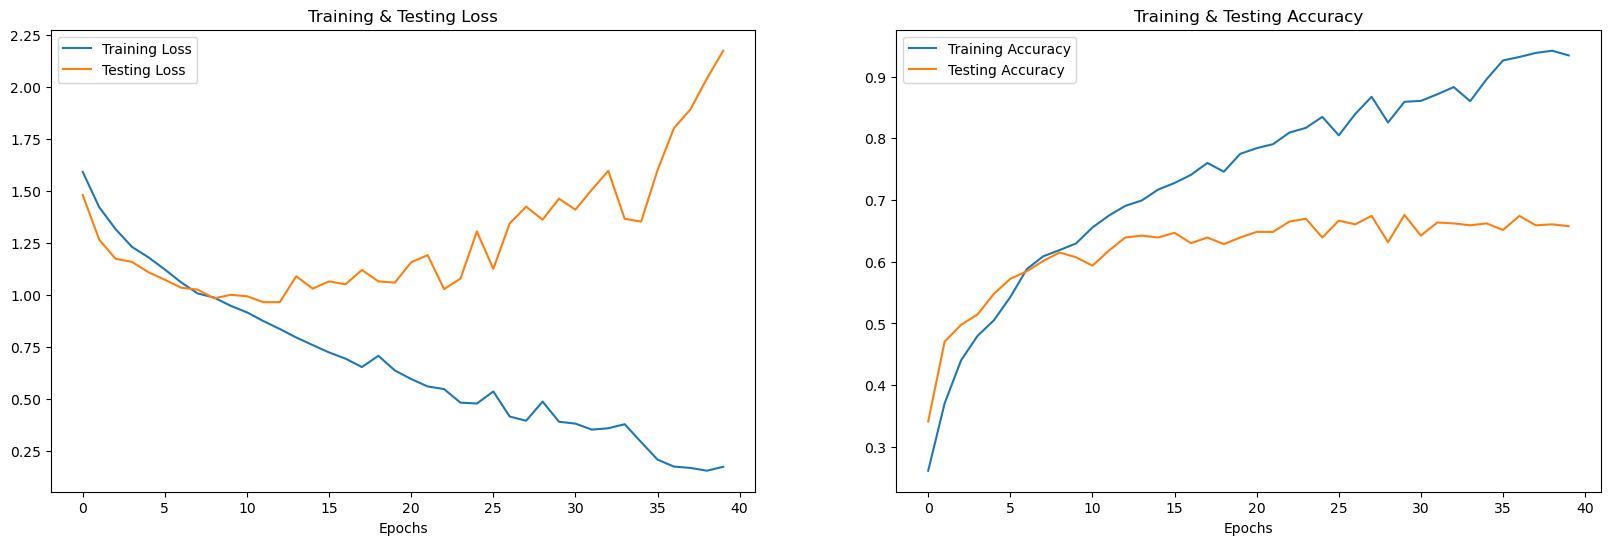

In [15]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")
epochs = [i for i in range(40)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
test_acc = history.history['val_acc']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [16]:
# predicting on test data.
pred_test = model.predict(X_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

28/28 [==============================] - 0s 4ms/step


In [17]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(20)

,Predicted Labels,Actual Labels
0,angry,happy
1,neutral,fear
2,sad,sad
3,angry,angry
4,sad,sad
5,happy,happy
6,fear,fear
7,neutral,neutral
8,fear,angry
9,fear,fear


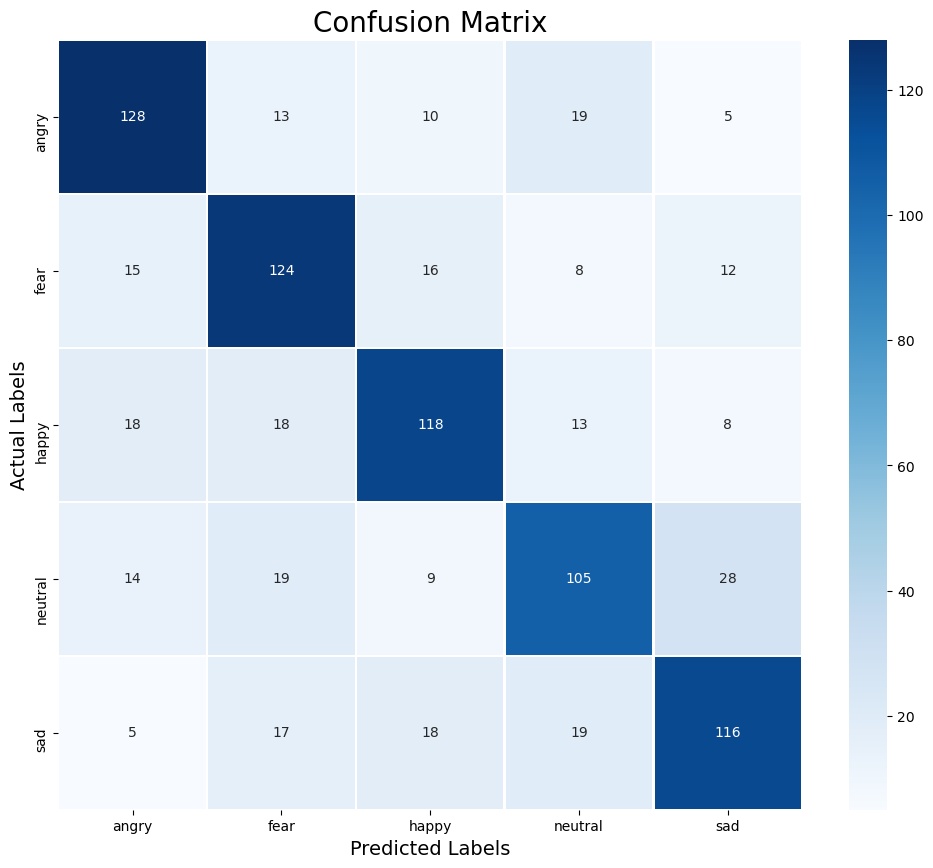

In [18]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sb.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.71      0.73      0.72       175
        fear       0.65      0.71      0.68       175
       happy       0.69      0.67      0.68       175
     neutral       0.64      0.60      0.62       175
         sad       0.69      0.66      0.67       175

    accuracy                           0.68       875
   macro avg       0.68      0.68      0.67       875
weighted avg       0.68      0.68      0.67       875



# Save model

In [20]:
# Export model
model.save('./chris_nlp_model.h5')
saved_model = keras.models.load_model('./nlp_model.h5')